## <center>Inicio

In [2]:
# Importación de librerías

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import random

In [3]:
import re
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

In [5]:
from sklearn.utils import shuffle

In [6]:
import xgboost as xgb

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import kerastuner as kt
from kerastuner.tuners import BayesianOptimization

In [ ]:
# Importación de los documentos

tw_train = pd.read_csv('./train.csv')
tw_test = pd.read_csv('./test.csv')
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150

## <center>Preprocesamiento y Feature Extraction a partir de 'text'

In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

regexes = {'hashtags':r'(#)+', 'mentions':r'(@)\w*', 'URLs':r'(http://)[a-zA-Z0-9./]*'}

referenceDF = pd.read_csv('./headlines_reference_values.csv').drop(columns = 'Unnamed: 0')
ref = referenceDF.loc[0]

basicStopwords = stopwords.words('english')
myStopwords = set(basicStopwords + list(punctuation))

In [7]:
def isInText(DF, feature):
    DF[feature[0]+'_in_t'] = 0   # Inicialización de la nueva columna
    for i in range(len(DF)):
        try:
            if (DF.loc[i, feature]).lower() in (DF.loc[i, 'text']).lower(): DF.loc[i, feature[0]+'_in_t'] = 1
        except:
            continue
        
def replace_contractions(text, mapping):
    noContText = []
    counter = 0
    for t in text.split(" "):
        if t.lower() in mapping:
            noContText.append(mapping[t.lower()])
            counter += 1
        else:
            noContText.append(t) 
    return [' '.join(noContText), counter]

def Qy(regex, text):   
    try:
        return len(re.compile(regex).findall(text))
    except:
        return 0

def newFeatures(DF, regexDict):
    for k, v in regexDict.items():
        DF[['text', k]] = pd.DataFrame(DF['text'].map(lambda x: [re.compile(v).sub(r' ', x), Qy(v, x)]).tolist())

def wilsonScore(num, den):
    if num == 0:
        return round(0, 2)
    phat = num/den
    z = 1.96
    return round(((phat + z*z/(2*den) - z * np.sqrt((phat*(1-phat)+z*z/(4*den))/den))/(1+z*z/den)), 2)

def tagging(text):
    tagsCount = {'ADJ':0, 'ADP':0, 'ADV':0, 'CONJ':0, 'DET':0, 'NOUN':0, 'NUM':0, 'PRT':0, 'PRON':0, 'VERB':0, '.':0, 'X':0}
    tags = []
    sentences = sent_tokenize(text)
    for sentence in sentences:
        tags += nltk.pos_tag(word_tokenize(sentence), tagset = 'universal')
    for word, tag in tags:
        tagsCount[tag] += 1    
    POS_ratio = [round((12 - list(tagsCount.values()).count(0))/12, 2)]
#     mostCommonPOS_ratio = [round(list(tagsCount.values()).count(max(tagsCount.values()))/(12-list(tagsCount.values()).count(0)), 2)]
    mostCommonPOS_ratio = [wilsonScore(list(tagsCount.values()).count(max(tagsCount.values())), 12-list(tagsCount.values()).count(0))]
    noun_ratio =  [wilsonScore(tagsCount['NOUN'], sum(tagsCount.values()))]
    return list(tagsCount.values()) + POS_ratio + mostCommonPOS_ratio + noun_ratio

def headlinesDistance(DF, ref):
    DF['dist'] = 0
    for i in range(len(DF)):
        x = DF.loc[i, ['textLenght','ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X','POS_ratio','topPOS_ratio','NOUN/TOT', 'polarity', 'subjectivity']]
        DF.loc[i, 'dist'] =  np.dot(x, ref)/(np.linalg.norm(x)*np.linalg.norm(ref))

def sentimentAnalysis(text):
    blob = TextBlob(text)
    return blob.sentiment

def stemmizer(text, stopwords):
    words = word_tokenize(text)
    return ' '.join([PorterStemmer().stem(word) for word in words if word not in stopwords])

def SWRemoval(text, stopwords):
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in stopwords])
    
def preprocessing(DF, contraction_mapping, regexes, ref, myStopwords):
#     originalTextLength = tw_train['text'].map(lambda x: len(x))
    isInText(DF, 'keyword')
    isInText(DF, 'location')
    DF[['text', 'conts']] = pd.DataFrame(DF['text'].map(lambda x: replace_contractions(x, contraction_mapping)).tolist())
    originalTextLength = DF['text'].map(lambda x: len(x))
    newFeatures(DF, regexes) 
    DF['textLenght'] = DF['text'].map(lambda x: len(x))
#     DF['textTrash'] = originalTextLength - DF['textLenght']
    DF[['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X','POS_ratio','topPOS_ratio','NOUN/TOT']] = pd.DataFrame(DF['text'].map(lambda x: tagging(x)).tolist())
    DF[['polarity', 'subjectivity']] = pd.DataFrame(DF['text'].map(lambda x: sentimentAnalysis(x)).tolist())
    headlinesDistance(DF, ref)
    DF['K'] = DF['textLenght']*DF['NOUN/TOT']*DF['polarity']
    DF['text'] = DF['text'].map(lambda x: x.lower())
    DF['text'] = DF['text'].map(lambda x: re.compile(r'\d').sub(r' ', x))
#     DF['text'] = DF['text'].map(lambda x: stemmizer(x, myStopwords))
    DF['text'] = DF['text'].map(lambda x: SWRemoval(x, myStopwords))
    DF['textTrash'] = originalTextLength - DF['textLenght']    

In [10]:
# Preprocesamiento y feature extraction del text

preprocessing(tw_train, contraction_mapping, regexes, ref, myStopwords)
preprocessing(tw_test, contraction_mapping, regexes, ref, myStopwords)

## <center>Vocabulario - Embeddings

In [11]:
# Vocabulary
# las Stopwords ya quedaron afuera en el paso anterior

textList = tw_train['text'].tolist()
text = ' '.join(textList)
tokens = word_tokenize(text)
tokensFreq = nltk.FreqDist(tokens)
tokensFreq = {k:v for k,v in tokensFreq.items() if (v>5) & (v<150)}
myVocabulary = list(tokensFreq.keys())
print('El vocabulario consta de {} palabras'.format(len(myVocabulary)))

El vocabulario consta de 2173 palabras


In [27]:
# Embeddings

embeddingsFilePath = './glove.twitter.27B.100d.txt'
embeddingsFile = open(embeddingsFilePath)
embeddingsIndex = {}
for line in embeddingsFile:
    lineList = line.split()
    word = lineList[0]
    vector = np.array(lineList[1:])
    embeddingsIndex[word] = vector
embeddingsFile.close()

In [13]:
def embeddingsInVoc(voc):
    noEmbeddingTokens = []
    for token in voc:
        if token.lower() not in embeddingsIndex:
            noEmbeddingTokens.append(token)
    print('{}% de los tokens tienen embedding'.format( 100 - round((len(noEmbeddingTokens)/len(voc))*100, 2) ))
    return noEmbeddingTokens

noEmbeddingTokens = embeddingsInVoc(myVocabulary)

96.82% de los tokens tienen embedding


In [14]:
tokensReplacement = {'icemoon':'ice moon','bioterror':'bio terror','bioterrorism':'bio terrorism','microlight':'micro light',
                     'w/heavenly':'heavenly','typhoon-devastated':'typhoon devastated',"'save":'save','animalrescue':'animal rescue',
                     'mediterran':'mediterranean','meat-loving':'meat loving',"'suicide":'suicide'}
tokensDeletion = set(tokensReplacement.keys()) ^ set(noEmbeddingTokens)

In [15]:
# Últimos detalles sobre la limpieza del texto
def replace_noEmbeddingTokens(text, replacement_mapping, deletion_list):
    newText = []
    for word in word_tokenize(text):
        if word.lower() in replacement_mapping:
            newText.append(replacement_mapping[word.lower()])
        elif word.lower() not in deletion_list:
            newText.append(word) 
    return ' '.join(newText)

tw_train['text'] = tw_train['text'].map(lambda x: replace_noEmbeddingTokens(x, tokensReplacement, tokensDeletion))
tw_test['text'] = tw_test['text'].map(lambda x: replace_noEmbeddingTokens(x, tokensReplacement, tokensDeletion))

In [16]:
# Redefino vocabulario
myVocabulary = [w for w in myVocabulary if w not in tokensDeletion]
myVocabulary = [tokensReplacement[w] if (w in tokensReplacement) else w for w in myVocabulary]
myVocabulary = list(set(myVocabulary))
print('El nuevo vocabulario consta de {} palabras'.format(len(myVocabulary)))

El nuevo vocabulario consta de 2112 palabras


In [17]:
noEmbeddingTokens = embeddingsInVoc(myVocabulary)

99.67% de los tokens tienen embedding


### Resultados

In [18]:
tw_train.to_csv('tw_train.csv', index = False)
tw_test.to_csv('tw_test.csv', index = False)

with open('myVocabulary.pickle', 'wb') as f:
    pickle.dump(myVocabulary, f)

### Carga de los resultados

In [8]:
with open('myVocabulary.pickle', 'rb') as f:
    myVocabulary = pickle.load(f)

### Más de embeddings

In [9]:
# Creación de un Vocabulary Index
# El índice cero y el índice 1 se reservan para padding y "out of index", respectivamente.

vocabularyIndex = {}
for i in range(2, len(myVocabulary)+2):  # myVocabulary es una lista ya creada anteriormente
    vocabularyIndex[myVocabulary[i-2]] = i
    
# Construcción de la embedding matrix

num_tokens = len(vocabularyIndex) + 2
embeddings_dim = 100
embeddingsMatrix = np.zeros((num_tokens, embeddings_dim))
for word, i in vocabularyIndex.items():
    embedding_vector = embeddingsIndex.get(word)
    if embedding_vector is not None:
        embeddingsMatrix[i] = embedding_vector
    else:
        continue
print('La embeddingsMatrix resultante tiene las dimensiones {}'.format(embeddingsMatrix.shape))

# Construcción de los vectores de entrada

def vocMapping(text):
    vector = []
    for word in word_tokenize(text):
        try:
            vector.append(vocabularyIndex[word])
        except:
            vector.append(1)  # Embeddings desconocidos
    vector = vector + [0]*(num_tokens - len(vector))  # Padding
    return np.array(vector).astype(np.float)

La embeddingsMatrix resultante tiene las dimensiones (2114, 100)


## <center>Data Augmentation: Creación de un nuevo set de train basado en ruido

In [20]:
# Data a utilizar: embeddingsIndex, que es el diccionario tal que (k, v) = (word, embedding)
# Lo reduzco a una forma que contenga solo las claves que también se encuentran en myVocabulary

myEmbeddingsIndex = {k:v.astype(np.float) for k,v in embeddingsIndex.items() if k in myVocabulary}

In [21]:
def text_mutation(text, embDict):
    words = text.split()
    for i in range(len(words)):
        if words[i].lower() in embDict:
            minDistance = -1
            newWord = words[i]
            for k, v in embDict.items():
                if k != words[i].lower():
                    distance = np.dot(embDict[words[i].lower()], v)/(np.linalg.norm(embDict[words[i].lower()])*np.linalg.norm(v))
                    if (1 - distance) < (1 - minDistance):
                        minDistance = distance
                        newWord = k
            words[i] = newWord
    words.insert(random.randint(0, len(words)-1) ,list(embDict.keys())[random.randint(0, len(embDict)-1)])
    return ' '.join(words)

In [22]:
def noisy_preprocessing(DF, contraction_mapping, regexes, ref, myStopwords, myEmbeddingsIndex):
    isInText(DF, 'keyword')
    isInText(DF, 'location')
    DF[['text', 'conts']] = pd.DataFrame(DF['text'].map(lambda x: replace_contractions(x, contraction_mapping)).tolist())
    newFeatures(DF, {'hashtags':r'(#)+'})
    DF['text'] = DF['text'].map(lambda x: text_mutation(x, myEmbeddingsIndex))
    originalTextLength = DF['text'].map(lambda x: len(x))
    newFeatures(DF, {'mentions':r'(@)\w*', 'URLs':r'(http://)[a-zA-Z0-9./]*'})
    DF['textLenght'] = DF['text'].map(lambda x: len(x))
    DF[['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X','POS_ratio','topPOS_ratio','NOUN/TOT']] = pd.DataFrame(DF['text'].map(lambda x: tagging(x)).tolist())
    DF[['polarity', 'subjectivity']] = pd.DataFrame(DF['text'].map(lambda x: sentimentAnalysis(x)).tolist())
    headlinesDistance(DF, ref)
    DF['K'] = DF['textLenght']*DF['NOUN/TOT']*DF['polarity']
    DF['text'] = DF['text'].map(lambda x: x.lower())
    DF['text'] = DF['text'].map(lambda x: re.compile(r'\d').sub(r' ', x))
    DF['text'] = DF['text'].map(lambda x: SWRemoval(x, myStopwords))
    DF['textTrash'] = originalTextLength - DF['textLenght']
    DF['text'] = DF['text'].map(lambda x: replace_noEmbeddingTokens(x, tokensReplacement, tokensDeletion))

In [23]:
tw_train_noise = pd.read_csv('./train.csv')

In [24]:
noisy_preprocessing(tw_train_noise, contraction_mapping, regexes, ref, myStopwords, myEmbeddingsIndex)

In [36]:
print(f'''Para ilustrar la diferencia:
Original: {tw_train.loc[150,'text']}
Mutado: {tw_train_noise.loc[150,'text']}''')

Para ilustrar la diferencia:
Original: might killed airplane accident night car wreck politics best
Mutado: could murdered plane crash tonight truck wreck politics inch best


In [42]:
print(f'''Para ilustrar la diferencia:
Original: {tw_train.loc[0,'text']}
Mutado: {tw_train_noise.loc[0,'text']}''')

Para ilustrar la diferencia:
Original: deeds reason earthquake may allah forgive us
Mutado: deeds wrong officers tornado close islam forgive bring


In [26]:
tw_train_noise = tw_train_noise[list(tw_train.columns)]

### Resultados:

### Uso: Para balancear el Train Set original

In [9]:
def balance(clean, noise):
    delta = clean['target'].value_counts().loc[0] - clean['target'].value_counts().loc[1]
    if delta > 0:
        add_balance = noise.loc[noise['target'] == 1, :].sample(n = abs(delta), replace = False, random_state = 60)
    elif delta < 0:
        add_balance = noise.loc[noise['target'] == 0, :].sample(n = abs(delta), replace = False, random_state = 60)
    balanced = pd.concat([clean, add_balance], axis=0, join = 'outer', ignore_index = True)    
    return shuffle(balanced)

### Uso: Para agragar ruido

In [10]:
def add_noise(clean, noise, noise_level,keep_proportion = True, return_residual_noise = False):
    
    if keep_proportion == True:
        stratify = noise['target']
    else:
        stratify = None
        
    residual_noise, noise_required = train_test_split(noise, stratify = stratify, test_size = noise_level)
    noisyDF = pd.concat([clean, noise_required], axis=0, join = 'outer', ignore_index = True)
    
    if return_residual_noise == False:
        return shuffle(noisyDF)
    else:
        return shuffle(noisyDF), shuffle(residual_noise)

## <center>Visualización de los datos (¿Se pueden distinguir los target?)

In [57]:
SVD = TruncatedSVD(n_components=2, n_iter=7, random_state=678)
X_svd = SVD.fit_transform(X)

In [58]:
scatter_data = np.concatenate((X_svd, np.array(tw_train['target']).reshape(-1,1)), axis = 1)

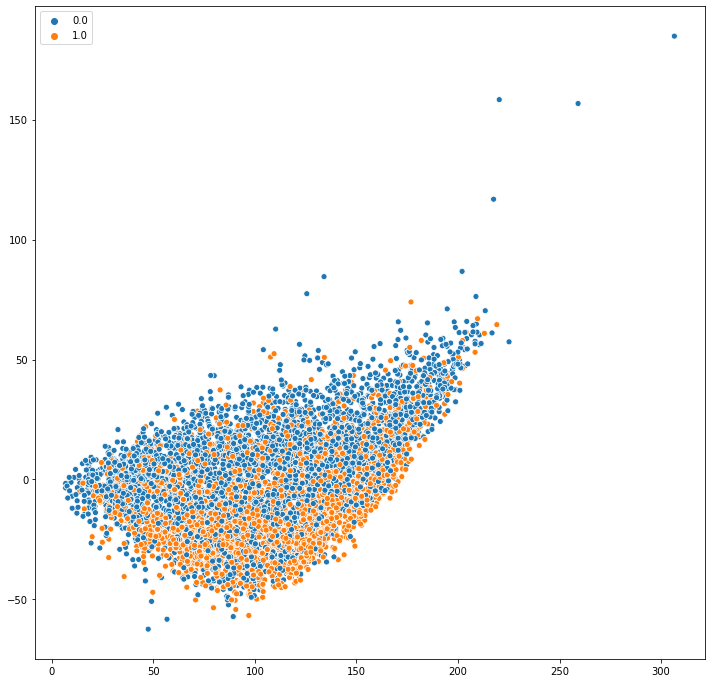

In [59]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
sns.scatterplot(ax = ax, x = scatter_data[:, 0], y = scatter_data[:, 1], hue = scatter_data[:, 2])

In [60]:
from sklearn.decomposition import KernelPCA

In [63]:
kpca = KernelPCA(n_components = 2, kernel = 'poly', random_state = 456)

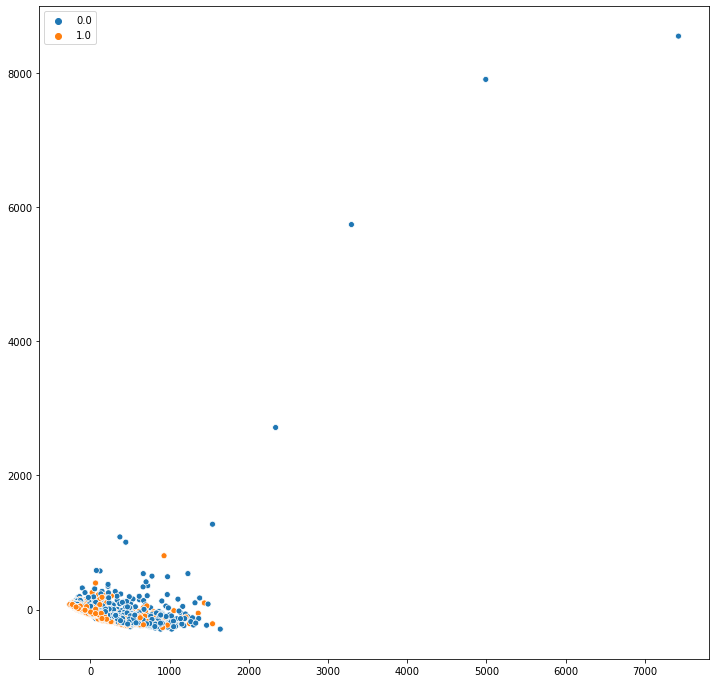

In [64]:
X_kpca = kpca.fit_transform(X)
scatter_data = np.concatenate((X_kpca, np.array(tw_train['target']).reshape(-1,1)), axis = 1)
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
sns.scatterplot(ax = ax, x = scatter_data[:, 0], y = scatter_data[:, 1], hue = scatter_data[:, 2])

## Random forest: Feature importance

In [ ]:
# SET DE DATOS: OPCION 1: CON EL TRAIN SET TAL CUAL
tw_train = pd.read_csv('./tw_train.csv')
tw_train['text'] = tw_train['text'].astype('str')
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')

In [ ]:
# SET DE DATOS: OPCION 1.2: Sacando l_in_t, k_in_t, X 
tw_train = pd.read_csv('./tw_train.csv')
tw_train['text'] = tw_train['text'].astype('str')
tw_train = tw_train.drop(columns = ['l_in_t', 'k_in_t', 'X'])
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')
tw_test = tw_test.drop(columns = ['l_in_t', 'k_in_t', 'X'])

In [90]:
# SET DE DATOS: OPCION 2: AGREGANDO RUIDO AL TRAIN SET PARA BALANCEAR
tw_train = pd.read_csv('./tw_train.csv')
tw_train['text'] = tw_train['text'].astype('str')
tw_train = tw_train.drop(columns = ['l_in_t', 'k_in_t', 'X'])
tw_train_noise = pd.read_csv('./tw_train_noise.csv')
tw_train_noise['text'] = tw_train_noise['text'].astype('str')
tw_train_noise = tw_train_noise.drop(columns = ['l_in_t', 'k_in_t', 'X'])
tw_train_balanced = balance(tw_train, tw_train_noise)
tw_train = tw_train_balanced
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')
tw_test = tw_test.drop(columns = ['l_in_t', 'k_in_t', 'X'])

In [ ]:
# SET DE DATOS OPCIÓN 3: AGREGANDO RUIDO AL TRAIN SET MANTENIENDO DESBALANCE
tw_train = pd.read_csv('./tw_train.csv')
tw_train['text'] = tw_train['text'].astype('str')
tw_train_noise = pd.read_csv('./tw_train_noise.csv')
tw_train_noise['text'] = tw_train_noise['text'].astype('str')
tw_train_noisy = add_noise(tw_train, tw_train_noise, 0.6, keep_proportion = True, return_residual_noise = False)
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')

In [ ]:
# SET DE DATOS OPCIÓN 4: USAR TODO EL TRAIN PARA ENTRENAR Y RUIDO PARA VALIDAR
tw_train = pd.read_csv('./tw_train.csv')
tw_train['text'] = tw_train['text'].astype('str')
tw_train_noise = pd.read_csv('./tw_train_noise.csv')
tw_train_noise['text'] = tw_train_noise['text'].astype('str')
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')

In [28]:
# SET DE DATOS OPCION 5: CON UN SET DE DATOS EXTENDIDO Y BALANCEADO
tw_train = pd.read_csv('./tw_train.csv')
tw_train['text'] = tw_train['text'].astype('str')
# tw_train = tw_train.drop(columns = ['l_in_t', 'k_in_t', 'X'])
tw_train_noise = pd.read_csv('./tw_train_noise.csv')
tw_train_noise['text'] = tw_train_noise['text'].astype('str')
# tw_train_noise = tw_train_noise.drop(columns = ['l_in_t', 'k_in_t', 'X'])
tw_train_noisy, residual_noise = add_noise(tw_train, tw_train_noise, 0.50, keep_proportion = True, return_residual_noise = True)
tw_train_noisy_balanced = balance(tw_train_noisy, residual_noise)
tw_train = tw_train_noisy_balanced
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')
# tw_test = tw_test.drop(columns = ['l_in_t', 'k_in_t', 'X'])

In [29]:
# Encoding de keyword

# Entreno el encoder sin los NaN. Luego, les doy un valor arbitrario no contenido en el conjunto de categorías original de manera que, 
# en la tranformación, se les asigne el vector nulo
ohe = OneHotEncoder(handle_unknown = 'ignore')
ohe.fit(np.array(tw_train.loc[tw_train['keyword'].isna() == False, 'keyword']).reshape((-1,1)))
tw_train['keyword'].fillna('NoKeyword', inplace = True)
tw_train_keyword_enc = ohe.transform(np.array(tw_train['keyword']).reshape((-1,1)))
tw_test['keyword'].fillna('NoKeyword', inplace = True)
tw_test_keyword_enc = ohe.transform(np.array(tw_test['keyword']).reshape((-1,1)))

In [30]:
print('El encoding genera {} nuevos features'.format(tw_train_keyword_enc.shape[1]))

El encoding genera 221 nuevos features


In [31]:
def embed(text):
    addition = np.zeros((100,))
    for word in word_tokenize(text):
        try:
            addition += np.array(embeddingsIndex[word.lower()]).astype(np.float)
        except:
            continue
    return addition

tw_train_text_embedded = np.stack(tw_train['text'].map(lambda x: embed(x)))
tw_test_text_embedded = np.stack(tw_test['text'].map(lambda x: embed(x)))

In [32]:
print(f'El embedding genera {tw_train_text_embedded.shape[1]} nuevos features')

El embedding genera 100 nuevos features


In [33]:
# Conformación de los sets de datos

tw_train_subset = tw_train.drop(columns = ['id', 'keyword', 'location', 'text', 'target'])
X = sparse.hstack((tw_train_text_embedded, sparse.csr_matrix(tw_train_subset.values)))
X = sparse.hstack((tw_train_keyword_enc, X))
y = tw_train['target']

tw_test_subset = tw_test.drop(columns = ['id', 'keyword', 'location', 'text'])
X_test = sparse.hstack((tw_test_text_embedded, sparse.csr_matrix(tw_test_subset.values)))
X_test = sparse.hstack((tw_test_keyword_enc, X_test))

In [103]:
# Conformación de los sets de datos sin encoding

tw_train_subset = tw_train.drop(columns = ['id', 'keyword', 'location', 'text', 'target'])
X = sparse.hstack((tw_train_text_embedded, sparse.csr_matrix(tw_train_subset.values)))
y = tw_train['target']

tw_test_subset = tw_test.drop(columns = ['id', 'keyword', 'location', 'text'])
X_test = sparse.hstack((tw_test_text_embedded, sparse.csr_matrix(tw_test_subset.values)))

In [34]:
# Separación del set de validación

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, test_size=0.20, random_state=123)

In [35]:
print(
    '''Las dimensiones de los sets de datos son:
    Set de entrenamiento: {}
    Set de validación: {}
    Set de test: {}'''.format(X_train.shape, X_val.shape,X_test.shape)
)

Las dimensiones de los sets de datos son:
    Set de entrenamiento: (10420, 348)
    Set de validación: (2606, 348)
    Set de test: (3263, 348)


In [36]:
# Entrenamiento del clasificador
rfc = RandomForestClassifier(n_estimators = 300, random_state = 158)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=158)

In [37]:
# Evaluación del error de entrenamiento
rfc.score(X_train, y_train)

0.9945297504798465

In [38]:
# Predicción sobre el Validation Set
predicted_0 = rfc.predict(X_val)

In [39]:
# Evaluación de la predicción
print('El F1-Score es: {} \n'.format(f1_score(y_val, predicted_0)))
print('La confusion matrix es: \n{} \n'.format(confusion_matrix(y_val, predicted_0)))
print('El classification report es: \n{} \n'.format(classification_report(y_val, predicted_0)))

El F1-Score es: 0.8121787267694742 

La confusion matrix es: 
[[1104  199]
 [ 276 1027]] 

El classification report es: 
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1303
           1       0.84      0.79      0.81      1303

    accuracy                           0.82      2606
   macro avg       0.82      0.82      0.82      2606
weighted avg       0.82      0.82      0.82      2606
 



In [23]:
results = pd.read_csv('./results.csv')

In [40]:
# Más evaluación
predicted_test = rfc.predict(X_test)
print('ERROR DE SUBMIT:\n')
print('El F1-Score es: {} \n'.format(f1_score(results['target'], predicted_test)))
print('La confusion matrix es: \n{} \n'.format(confusion_matrix(results['target'], predicted_test)))
print('El classification report es: \n{} \n'.format(classification_report(results['target'], predicted_test)))

ERROR DE SUBMIT:

El F1-Score es: 0.7472775065715358 

La confusion matrix es: 
[[1595  266]
 [ 407  995]] 

El classification report es: 
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1861
           1       0.79      0.71      0.75      1402

    accuracy                           0.79      3263
   macro avg       0.79      0.78      0.79      3263
weighted avg       0.79      0.79      0.79      3263
 



In [41]:
# Feature ranking
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

myTopFeatures = []
print("Feature ranking:")
for f in range(X.shape[1]):   
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    if indices[f] >= 321:
        myTopFeatures.append((f + 1, indices[f], importances[indices[f]]))
# print([indices[f] for f in range(80)])

Feature ranking:
1. feature 290 (0.037201)
2. feature 282 (0.036330)
3. feature 250 (0.030853)
4. feature 303 (0.026660)
5. feature 247 (0.023363)
6. feature 236 (0.021616)
7. feature 242 (0.020314)
8. feature 235 (0.018018)
9. feature 304 (0.017619)
10. feature 221 (0.016630)
11. feature 222 (0.015738)
12. feature 302 (0.015215)
13. feature 258 (0.014400)
14. feature 262 (0.014336)
15. feature 345 (0.012792)
16. feature 299 (0.012521)
17. feature 283 (0.012094)
18. feature 266 (0.010320)
19. feature 251 (0.009826)
20. feature 307 (0.009466)
21. feature 273 (0.009152)
22. feature 261 (0.009079)
23. feature 297 (0.009025)
24. feature 246 (0.008986)
25. feature 274 (0.008888)
26. feature 230 (0.008678)
27. feature 224 (0.008677)
28. feature 279 (0.008629)
29. feature 293 (0.008553)
30. feature 245 (0.008542)
31. feature 342 (0.008308)
32. feature 336 (0.008171)
33. feature 288 (0.008063)
34. feature 244 (0.007921)
35. feature 264 (0.007773)
36. feature 347 (0.007723)
37. feature 223 (0.0

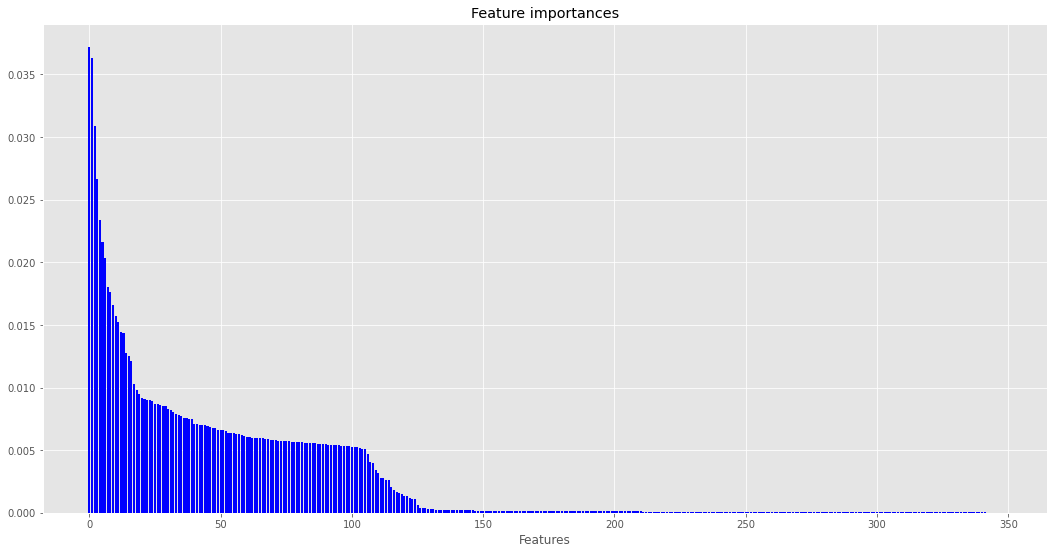

In [46]:
# Plot the impurity-based feature importances of the forest
plt.style.use('ggplot')
plt.figure(figsize = (18, 9))
plt.title("Feature importances")
# plt.bar(range(X.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
plt.xlabel('Features')
plt.bar(range(X.shape[1]), importances[indices],color="b")
# plt.xlim([-1, X.shape[1]])
plt.show()